### import library&data

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

from sklearn.cluster import KMeans

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [62]:
# 提出する予測値をaggrigationの特徴量を含むモデルにするか否か
AGG = False

In [63]:
COMP_PATH = "/kaggle/input/icr-identify-age-related-conditions"
train = pd.read_csv(f"{COMP_PATH}/train.csv")
test = pd.read_csv(f"{COMP_PATH}/test.csv")
sample_submission = pd.read_csv(f"{COMP_PATH}/sample_submission.csv")
greeks = pd.read_csv(f"{COMP_PATH}/greeks.csv")

### preprocess

In [64]:
# BQで分離
# あんまりデータ数少なくする前処理がいいソリューションじゃなさそうなので、一旦撤退
"""
train_droped = train.dropna(subset=["BQ"], how="any")
train_droped.reset_index(inplace=True)
train_droped.drop(["index"], axis=1, inplace=True)
train_droped.head()
"""

'\ntrain_droped = train.dropna(subset=["BQ"], how="any")\ntrain_droped.reset_index(inplace=True)\ntrain_droped.drop(["index"], axis=1, inplace=True)\ntrain_droped.head()\n'

In [65]:
# fillna
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


### metric

In [66]:
def competition_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    return (log_loss_0 + log_loss_1)/2

def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

In [67]:
def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

###  feature engineering

In [68]:
# Label encoding
train['EJ'] = train['EJ'].map({'A': 0, 'B': 1})
test['EJ']  = test['EJ'].map({'A': 0, 'B': 1})

In [69]:
# エルボー法によるK-meansの可視化関数の定義
def plot_kmeans(input_data, num_cluster):
    dist_list =[]
    for i in range(1,num_cluster):
        kmeans= KMeans(n_clusters=i, init='random', random_state=0)
        kmeans.fit(input_data)
        dist_list.append(kmeans.inertia_)
    
    # グラフを表示
    plt.plot(range(1,num_cluster), dist_list,marker='+')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')

In [70]:
# スケーリングの定義
def standard_scaling(input_data):
    scaler = StandardScaler()
    df = input_data.copy()
    new_num_cols = input_data.select_dtypes(include=['float64']).columns
    df[new_num_cols] = scaler.fit_transform(input_data[new_num_cols])
    
    return df

In [71]:
# スケーリングの実施
num_cols = train.select_dtypes(include=['float64']).columns
train_scaled = standard_scaling(train)
test_scaled = standard_scaling(test)

In [72]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [73]:
# K-Meansの可視化の上限設定
NUM_CLUSTER = 30

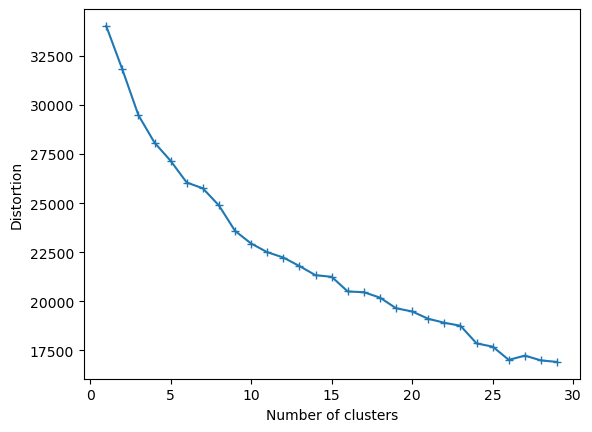

In [74]:
# エルボー法によるK-Meansの実施
plot_kmeans(train_scaled.drop(["Id", "EJ"], axis=1), NUM_CLUSTER)

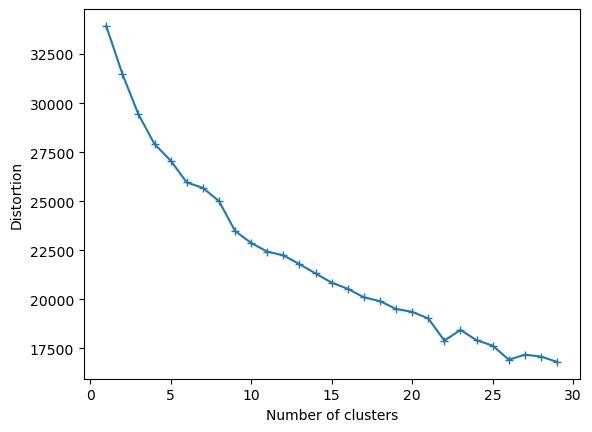

In [75]:
# クラスを含めない
plot_kmeans(train_scaled.drop(["Id", "EJ", "Class"], axis=1), NUM_CLUSTER)

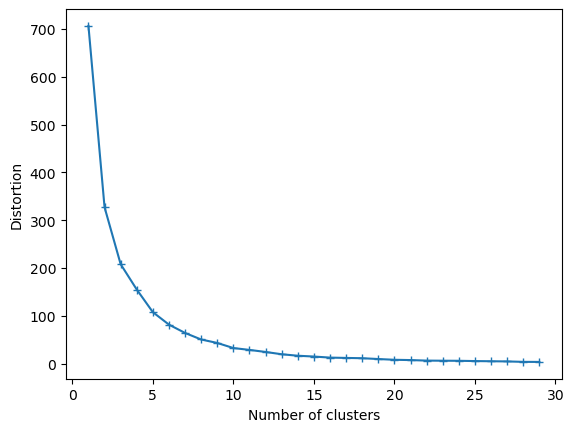

In [76]:
# BNカラム(=年齢カラム)とClassでK-Means
plot_kmeans(train_scaled[["BN", "Class"]], NUM_CLUSTER)

In [77]:
# クラスを含めない状態でクラスター数7でラベリング
num_cluster = 9

# kmeansクラスをインスタンス化
kmeans = KMeans(init='random', n_clusters=num_cluster, random_state=0)

# train dataでトレーニング
kmeans.fit(train_scaled.drop(["Id", "EJ", "Class"], axis=1))

# predict
km_label_train =pd.Series(kmeans.labels_, name='cluster_number_{}'.format(num_cluster))
km_label_test =pd.Series(kmeans.predict(test_scaled.drop(["Id", "EJ"], axis=1)), name='cluster_number_{}'.format(num_cluster))

In [78]:
# 本番データに結合
train_scaled["cluster_label"] = km_label_train
test_scaled["cluster_label"] = km_label_test

In [79]:
train_scaled.groupby(["cluster_label"])["Class"].sum()

cluster_label
0     8
1     7
2    19
3    14
4     0
5     2
6     1
7    55
8     2
Name: Class, dtype: int64

### training

In [80]:
df = train_scaled.copy()

In [81]:
# BQがnullでない行のgreeks['Alpha']の抽出
greeks_alpha = greeks.loc[(train["BQ"].isnull() == False), 'Alpha']

In [82]:
# prep for k-fold
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
df['fold'] = -1

for fold, (train_idx, test_idx) in enumerate(kf.split(df, greeks_alpha)):
    df.loc[test_idx, 'fold'] = fold

df.groupby('fold')["Class"].value_counts()

fold  Class
0     0        101
      1         23
1     0        102
      1         22
2     0        102
      1         21
3     0        102
      1         21
4     0        102
      1         21
Name: Class, dtype: int64

In [92]:
final_valid_predictions = {}
final_test_predictions = []
scores = []
train_log_losses = []
train_balanced_log_losses = []
log_losses = []
balanced_log_losses = []
weights = []

for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    
    lgb = LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000, 
                         early_stopping_round = 300, random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',
                         metric='none', is_unbalance=True, max_depth=8)
    
    lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000,
            eval_metric=lgb_metric)
    
    y_pred = lgb.predict_proba(X_valid)
    y_pred_train = lgb.predict_proba(X_train)
    preds_test = lgb.predict_proba(test_scaled.drop(['Id'], axis=1).values)
    
    final_test_predictions.append(preds_test)
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))
    
    # trainのlossの算出
    train_logloss = log_loss(y_train, y_pred_train)
    train_balanced_logloss = balanced_log_loss(y_train, y_pred_train[:, 1])
    
    # validのlossの算出
    logloss = log_loss(y_valid, y_pred)
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    
    # train scoreを算出
    train_log_losses.append(train_logloss)
    train_balanced_log_losses.append(train_balanced_logloss)
    
    # test scoreを算出
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    
    # test scoreを算出
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    weights.append(1/balanced_logloss)
    
    print(f"Fold: {fold}, log loss: {round(logloss, 3)}, balanced los loss: {round(balanced_logloss, 3)}")
    print(f"train log loss: {round(train_logloss, 3)}, train balanced los loss: {round(train_balanced_logloss, 3)}")

print()
print("Log Loss")
print(log_losses)
print(np.mean(log_losses), np.std(log_losses))
print()
print("Balanced Log Loss")
print(balanced_log_losses)
print("MEAN : ", np.mean(balanced_log_losses), "STD : ", np.std(balanced_log_losses))
print()
print("Weights")
print(weights)

Fold: 0, log loss: 0.285, balanced los loss: 0.181
train log loss: 0.177, train balanced los loss: 0.067
Fold: 1, log loss: 0.228, balanced los loss: 0.155
train log loss: 0.069, train balanced los loss: 0.027
[1000]	valid_0's balanced_log_loss: 0.0382535
Fold: 2, log loss: 0.066, balanced los loss: 0.037
train log loss: 0.0, train balanced los loss: 0.0
Fold: 3, log loss: 0.225, balanced los loss: 0.113
train log loss: 0.029, train balanced los loss: 0.011
Fold: 4, log loss: 0.214, balanced los loss: 0.127
train log loss: 0.065, train balanced los loss: 0.026

Log Loss
[0.28515326331693036, 0.28515326331693036, 0.22825198853777537, 0.22825198853777537, 0.06569877144826557, 0.06569877144826557, 0.22452336925195693, 0.22452336925195693, 0.21391452174805212, 0.21391452174805212]
0.20350838286059605 0.07323870411719272

Balanced Log Loss
[0.1812020525299704, 0.1812020525299704, 0.15469586246992476, 0.15469586246992476, 0.036722415905444304, 0.036722415905444304, 0.11279239474020746, 0.112

In [84]:
# 提出用データの確認
test_preds = np.zeros((test.shape[0],2))
for i in range(5):
    test_preds[:, 0] += weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += weights[i] * final_test_predictions[i][:, 1]
test_preds /= sum(weights)
test_preds

array([[0.94274303, 0.05725697],
       [0.94274303, 0.05725697],
       [0.94274303, 0.05725697],
       [0.94274303, 0.05725697],
       [0.94274303, 0.05725697]])

In [85]:
# 提出用データの作成
if AGG == False:
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ['Id', 'class_0', 'class_1']
    final_valid_predictions.to_csv(r"oof.csv", index=False)

    test_dict = {}
    test_dict.update(dict(zip(test.Id.values.tolist(), test_preds)))
    submission = pd.DataFrame.from_dict(test_dict, orient="index").reset_index()
    submission.columns = ['Id', 'class_0', 'class_1']

    # BQカラムがnullの場合
    #submission.loc[test["BQ"].isnull(), 'class_0'] = 1
    #submission.loc[test["BQ"].isnull(), 'class_1'] = 0

    submission.to_csv(r"submission.csv", index=False)
    print(submission.head())
else:
    pass

             Id   class_0   class_1
0  00eed32682bb  0.942743  0.057257
1  010ebe33f668  0.942743  0.057257
2  02fa521e1838  0.942743  0.057257
3  040e15f562a2  0.942743  0.057257
4  046e85c7cc7f  0.942743  0.057257


### aggrigationの実装

In [86]:
test_scaled["cluster_label"]

0    7
1    7
2    7
3    7
4    7
Name: cluster_label, dtype: int32

In [87]:
agg_cols = ['min', 'max', 'mean', 'std']
cat_cols = ["cluster_label"]

for col in cat_cols:
    grp_df = df.groupby(col)[num_cols].agg(agg_cols)
    grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
    df = df.merge(grp_df, on=col, how='left')
    test_scaled = test_scaled.merge(grp_df, on=col, how='left')    

In [88]:
final_valid_predictions = {}
final_test_predictions = []
scores = []
log_losses = []
balanced_log_losses = []
weights = []

for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    
    lgb = LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000, 
                         early_stopping_round = 300, random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',
                         metric='none', is_unbalance=True, max_depth=8)
    
    lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000,
            eval_metric=lgb_metric)
    
    y_pred = lgb.predict_proba(X_valid)
    preds_test = lgb.predict_proba(test_scaled.drop(['Id'], axis=1).values)
    
    final_test_predictions.append(preds_test)
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))

    logloss = log_loss(y_valid, y_pred)
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    weights.append(1/balanced_logloss)
    
    print(f"Fold: {fold}, log loss: {round(logloss, 3)}, balanced los loss: {round(balanced_logloss, 3)}")

print()
print("Log Loss")
print(log_losses)
print(np.mean(log_losses), np.std(log_losses))
print()
print("Balanced Log Loss")
print(balanced_log_losses)
print("MEAN : ", np.mean(balanced_log_losses), "STD : ", np.std(balanced_log_losses))
print()
print("Weights")
print(weights)

Fold: 0, log loss: 0.285, balanced los loss: 0.181
Fold: 1, log loss: 0.228, balanced los loss: 0.155
[1000]	valid_0's balanced_log_loss: 0.0382535
Fold: 2, log loss: 0.066, balanced los loss: 0.037
Fold: 3, log loss: 0.225, balanced los loss: 0.113
Fold: 4, log loss: 0.214, balanced los loss: 0.127

Log Loss
[0.28515326331693036, 0.22825198853777537, 0.06569877144826557, 0.22452336925195693, 0.21391452174805212]
0.20350838286059605 0.07323870411719272

Balanced Log Loss
[0.1812020525299704, 0.15469586246992476, 0.036722415905444304, 0.11279239474020746, 0.126747705116046]
MEAN :  0.12243208615231857 STD :  0.04889285428708696

Weights
[5.51870128421753, 6.4642970020896025, 27.231323847942814, 8.865845984592141, 7.889689198588907]


In [89]:
# 提出用データの確認
test_preds = np.zeros((test.shape[0],2))
for i in range(5):
    test_preds[:, 0] += weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += weights[i] * final_test_predictions[i][:, 1]
test_preds /= sum(weights)
test_preds

array([[0.92085438, 0.07914562],
       [0.92085438, 0.07914562],
       [0.92085438, 0.07914562],
       [0.92085438, 0.07914562],
       [0.92085438, 0.07914562]])

In [90]:
# 提出用データの作成
if AGG == True:
    final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    final_valid_predictions.columns = ['Id', 'class_0', 'class_1']
    final_valid_predictions.to_csv(r"oof.csv", index=False)

    test_dict = {}
    test_dict.update(dict(zip(test.Id.values.tolist(), test_preds)))
    submission = pd.DataFrame.from_dict(test_dict, orient="index").reset_index()
    submission.columns = ['Id', 'class_0', 'class_1']

    # BQカラムがnullの場合
    #submission.loc[test["BQ"].isnull(), 'class_0'] = 1
    #submission.loc[test["BQ"].isnull(), 'class_1'] = 0

    submission.to_csv(r"submission.csv", index=False)
    print(submission.head())
else:
    pass